In [98]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [99]:
NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((2,)),
        tf.keras.layers.Dense(units=32, activation="tanh"),
        tf.keras.layers.Dense(units=32, activation="tanh"),
        tf.keras.layers.Dense(units=1),
    ]
)

NN.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
NN.compile(optimizer="Adam", loss="mean_squared_error")

In [101]:
def ode_system(coord, net):
    coord = tf.constant(coord, dtype=tf.float32)
    # x = coord[..., 0]
    coord_0 = tf.zeros((1, 2))
    # y = coord[..., 1]
    # x = tf.constant(x, dtype=tf.float32)
    # y = tf.convert_to_tensor(y)
    with tf.GradientTape() as tape_first:
        tape_first.watch(coord)
        u = net(coord)
    u_coord = tape_first.gradient(u, coord)
    u_x = u_coord[..., 0]
    u_y = u_coord[..., 1]
    # print(u_coord)
    # u_coord = tape_first.gradient(u, coord)
    # u_x = u_coord[..., 0]
    # u_y = u_coord[..., 1]
    ode_loss = u_x + u_y - (coord[..., 0] * 2 + coord[..., 1] * 2)
    IC_loss = net(coord_0) - tf.zeros((1, 1))

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)
465.54056
146.51288
62.910286
30.113722
11.771512


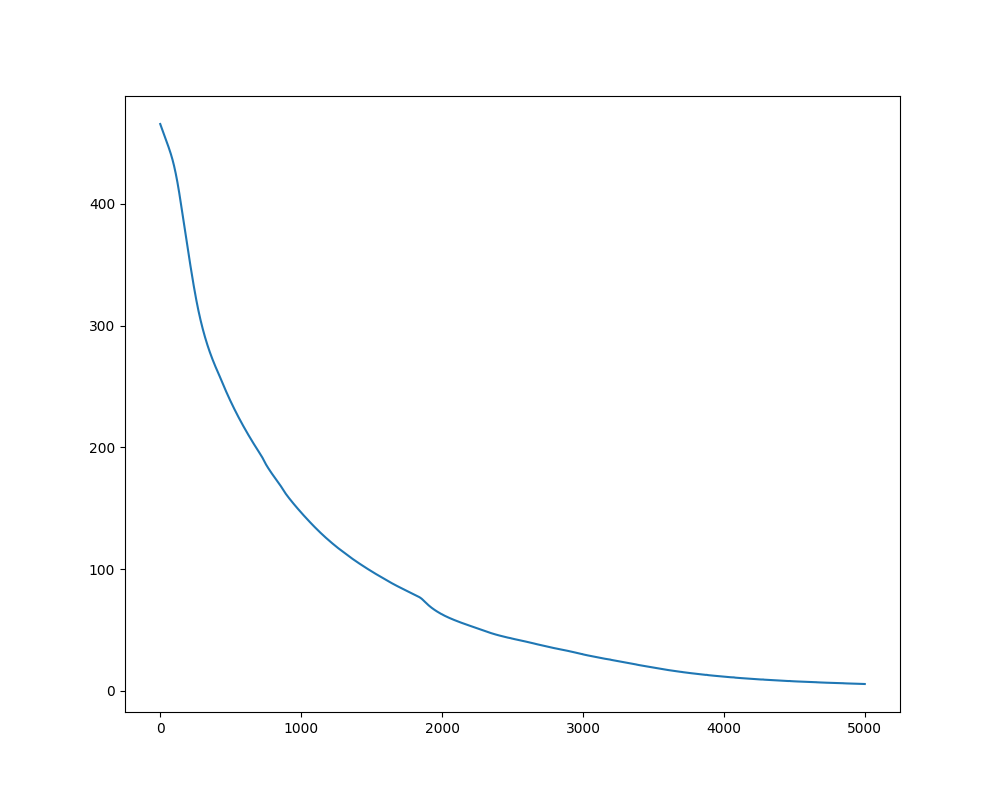

In [102]:
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
# y = np.random.uniform(1, 10, 10)
x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))
# train_coord = x
train_loss_record = []

print(tf.zeros((1, 2)))

for itr in range(5000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_coord, NN)
        train_loss_record.append(train_loss)

    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())
        
        if train_loss < 0.01:
            break

plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()

In [103]:
test_coord = np.linspace(0, 10, 100)

z = NN.predict(np.array([[1, 2]]))
print(z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[-82.46554]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
[[ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 ...
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]]


[(0.0, 10.0),
 (0.0, 10.0),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

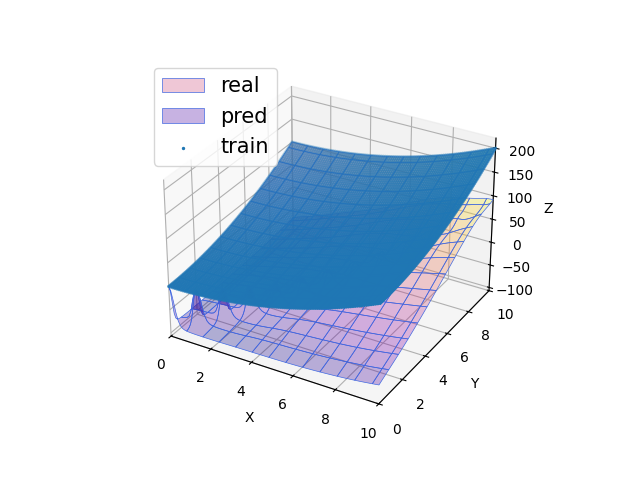

In [105]:
test_x = np.linspace(0, 10, 100)
test_y = np.linspace(0, 10, 100)
test_x, test_y = np.meshgrid(test_x, test_y)

train_u = x ** 2 + y ** 2
true_u = test_x ** 2 + test_y ** 2
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = NN.predict(np.array(pred_coord)).ravel().reshape(100, 100)
print(x)
# plt.figure(figsize=(10, 8))
# plt.plot(x, train_u, "ok", label="Train")
# plt.plot_s(test_x, true_u, "-k", label="True")
# plt.plot(test_t, pred_u, "--r", label="Prediction")
# plt.legend(fontsize=15)
# plt.xlabel("t", fontsize=15)
# plt.ylabel("u", fontsize=15)
# plt.show()
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(
    test_x,
    test_y,
    true_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.3,
    cmap="plasma",
    label="real"
)
ax.plot_surface(
    x,
    y,
    pred_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.3,
    cmap="plasma",
    label="pred",
)
ax.scatter(x, y, train_u, s=2, label="train")
ax.legend(fontsize=15)
ax.set(xlim=(0, 10), ylim=(0, 10), xlabel="X", ylabel="Y", zlabel="Z")